In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [80]:
M = 10
m = 5
c1 = 10
c2 = 10
g = 10
l = 0.25

In [81]:
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [-(4*(M + m)*(c1 + c2))/((M + m)*(4*M + m)), -(3 * (M + m) * m * g)/((M + m)*(4*M + m)), 0, 0],
              [(6 * (M + m) * (c1 + c2))/(l * (M + m)*(4*M + m)), (3 * g) / (2 * l) + (9 * (M + m) * m * g)/(2 * l * (M + m)*(4*M + m)), 0, 0]])

Метод Рунге - Кутты 4 порядка \
Рассмотрим задачу 
$$ y' = f(x, y), y(x_{0}) = y_{0} $$\
Тогда приближенное решение можно найти итерационно\
$$y_{n + 1} = y_{n} + \frac{h}{6}(k_{1} + 2k_{2} + 2k_{3} + k_{4}) $$
$$k_{1} = f(x_{n}, y_{n})$$
$$k_{2} = f(x_{n} + \frac{h}{2}, y_{n} + \frac{h}{2}k_{1})$$
$$k_{3} = f(x_{n} + \frac{h}{2}, y_{n} + \frac{h}{2}k_{2})$$
$$k_{4} = f(x_{n} + h, y_{n} + hk_{3})$$

In [82]:
def Linear_Runge_Kutta_4(start: float, stop: float, n: int, A: np.array, y_0: np.array) -> np.array:
    """
    :param start: Начало отрезка интегрирования 
    :param stop: Конец отрезка интегрирования
    :param n: Количество узловых точек
    :param A: Матрица перехода dx/dt = Ax
    :param y_0: Начальные условия 
    :return: Матрица, в первой строке узлы сетки, в остальных строках значение в этом узле.
    """
    grid = np.linspace(start, stop, n) # значение узлов сетки
    # так как сетка равномерная 
    h = (grid[n - 1] - grid[0]) / (n - 1)
    m, k = A.shape # m - число строк, k - число столбцов
    solution = np.zeros((m, n)) # m + 1 строка потому что в первой строке сетка, остальные m это строки матрицы A
    solution[:, 0] = y_0
    for i in range(1, n):
        k1 = A.dot(solution[:, i - 1])
        k2 = A.dot(solution[:, i - 1] + h * k1 / 2)
        k3 = A.dot(solution[:, i - 1] + h * k2 / 2)
        k4 = A.dot(solution[:, i - 1] + h * k3)
        solution[:, i] = solution[:, i - 1] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return grid, solution    
        
        
    
    

In [83]:
grid, solution = Runge_Kutta_4(0, 1, 10000, A, np.array([0, 1, 0, 0]))

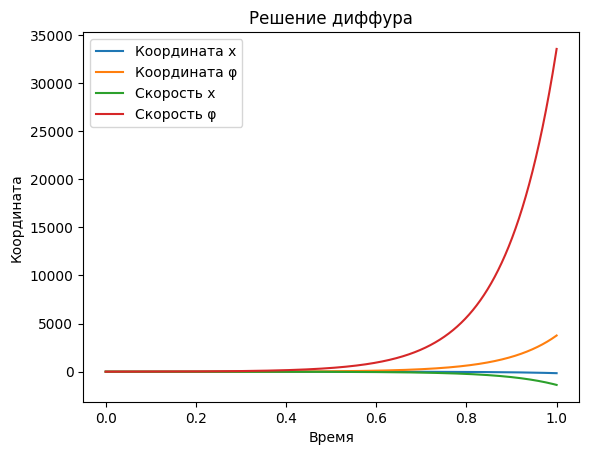

In [84]:
plt.plot(grid, solution[0, :], label='Координата x')
plt.plot(grid, solution[1, :], label='Координата φ')
plt.plot(grid, solution[2, :], label='Скорость x')
plt.plot(grid, solution[3, :], label='Скорость φ')
plt.xlabel('Время')
plt.ylabel('Координата')
plt.title('Решение диффура')
plt.legend()
plt.show()